In [1]:
import gradcam
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

import pandaGenerator
gradcam.seed_everything(gradcam.config.seed)



df = pd.read_csv("tiles/128_5_5.csv")
df = df.sample(frac=1, random_state=gradcam.config.seed).reset_index(drop=True)
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=gradcam.config.seed)



In [2]:
train_datagen = pandaGenerator.PANDAGenerator(
    df=train_df, 
    config=gradcam.config,
    mode='fit', 
    apply_tfms=False,
    shuffle=True, 
)

val_datagen = pandaGenerator.PANDAGenerator(
    df=valid_df, 
    config=gradcam.config,
    mode='fit', 
    apply_tfms=False,
    shuffle=False, 
)

Shape of X:  (2, 640, 640, 3)
Shape of y:  (2, 6)


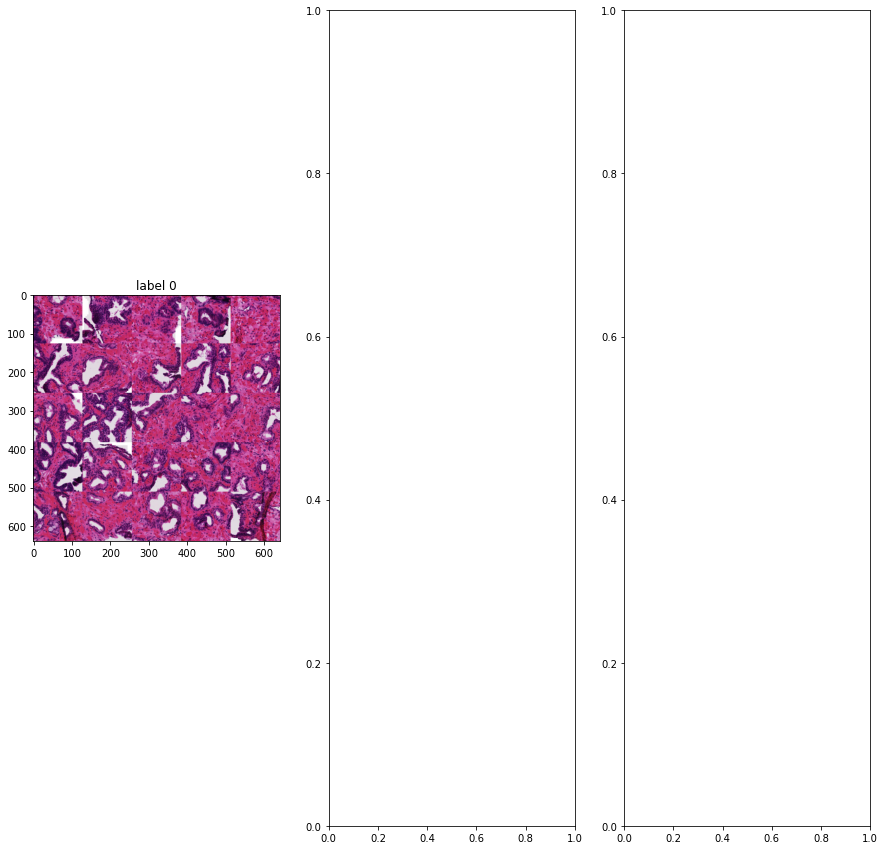

In [3]:
import matplotlib.pyplot as plt
import numpy as np

Xt, yt = train_datagen.__getitem__(0)

print('Shape of X: ', Xt.shape)
print('Shape of y: ', yt.shape)

fig, ax = plt.subplots(figsize=(15, 15), ncols=3)

for i in range(1):
    ax[i].imshow(Xt[i])
    ax[i].set_title('label {}'.format(np.argmax(yt[i, ])))
plt.show()



In [4]:
import models

model = models.build_seresnext()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 646, 646, 3)  0          ['input[0][0]']                  
                                                                                                  
 conv2d (Conv2D)                (None, 320, 320, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

cb1 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, verbose=1, min_lr=1e-6)
cb2 = ModelCheckpoint("best_seresnext50.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')



In [6]:


history = model.fit_generator(
    train_datagen,
    validation_data=val_datagen,
    callbacks=[cb1, cb2],
    epochs=gradcam.config.num_epochs,
    verbose=1
)



Epoch 1/5
1210/1210 [==============================] - ETA: 0s - loss: 1.8611 - cohen_kappa: 0.0039
Epoch 1: val_loss improved from inf to 18.73377, saving model to best_seresnext50.h5
1210/1210 [==============================] - 595s 471ms/step - loss: 1.8611 - cohen_kappa: 0.0039 - val_loss: 18.7338 - val_cohen_kappa: -0.0225 - lr: 0.0030
Epoch 2/5
1210/1210 [==============================] - ETA: 0s - loss: 1.8170 - cohen_kappa: 0.0406
Epoch 2: val_loss improved from 18.73377 to 12.29089, saving model to best_seresnext50.h5
1210/1210 [==============================] - 582s 481ms/step - loss: 1.8170 - cohen_kappa: 0.0406 - val_loss: 12.2909 - val_cohen_kappa: 0.1574 - lr: 0.0030
Epoch 3/5
1210/1210 [==============================] - ETA: 0s - loss: 1.8140 - cohen_kappa: 0.0751
Epoch 3: val_loss improved from 12.29089 to 1.79829, saving model to best_seresnext50.h5
1210/1210 [==============================] - 553s 457ms/step - loss: 1.8140 - cohen_kappa: 0.0751 - val_loss: 1.7983 - va

In [19]:
#  "Accuracy"
plt.plot(history.history['cohen_kappa'])
plt.plot(history.history['val_cohen_kappa'])
plt.title('model cohen kappa')
plt.ylabel('cohen kappa')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [5]:
model.load_weights('best_seresnext50.h5')

last_conv_layer_name = 'activation_80'
classifier_layer_names = [
    'global_average_pooling2d_16',
    'dense'
]

tf.Tensor([[0.16388436 0.19525991 0.16256358 0.15892099 0.16452062 0.15485045]], shape=(1, 6), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([[0.1652509  0.19811535 0.16379176 0.15838721 0.16330683 0.15114795]], shape=(1, 6), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([[0.16344689 0.1943545  0.16216968 0.15908559 0.16490263 0.15604068]], shape=(1, 6), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([[0.16137938 0.19013071 0.1603035  0.15982293 0.16666552 0.161698  ]], shape=(1, 6), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


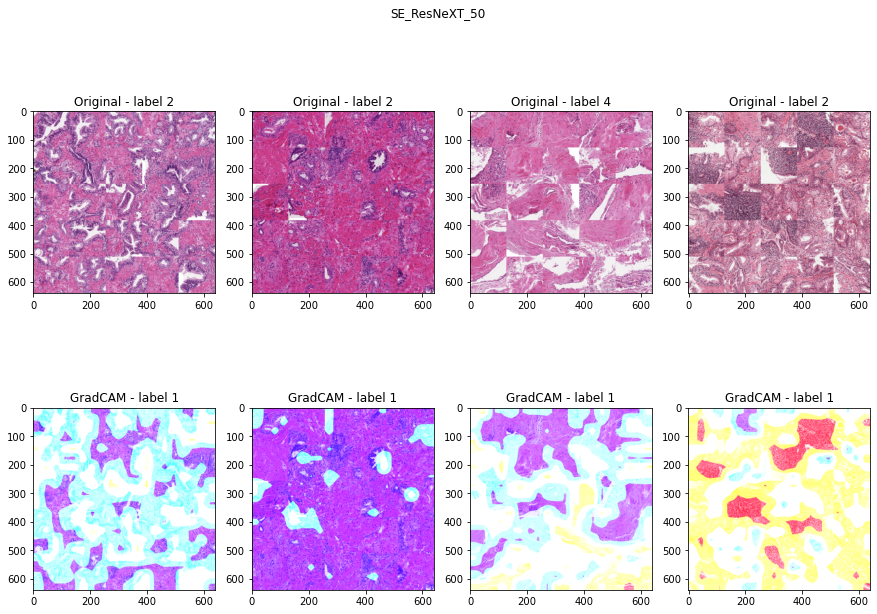

In [6]:
import matplotlib.pyplot as plt
import cv2
from numpy import random
fig, ax = plt.subplots(figsize=(15, 10), ncols=4, nrows=2)


for i in range(4):
    raw_image, y = train_datagen.__getitem__(random.randint(400))
    image = np.expand_dims(raw_image[0], axis=0)
    heatmap,prediction = gradcam.make_gradcam_heatmap(image, model, last_conv_layer_name, classifier_layer_names)
    superimposed_image = gradcam.create_superimposed_visualization(raw_image[0], heatmap,cv2.COLORMAP_JET)

    ax[0][i].imshow(raw_image[0])
    ax[0][i].set_title('Original - label {}'.format(np.argmax(y[0])))
    ax[1][i].imshow(superimposed_image)
    ax[1][i].set_title('GradCAM - label {}'.format(prediction))

fig.suptitle('SE_ResNeXT_50')
plt.show()